In [1]:
# Kristina Fauss
# April 19, 2024
# model selection by AIC testing all 1st order interactions

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from ols_mixedef_custom import *

In [2]:
fp = '/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/data/processed-data/main_dataset.csv'

flamog = pd.read_csv(fp)

# drop na's for flam metrics
print(len(flamog))
for col in ['fh', 'fd', 'pfg', 'temp_change', 'heat_flux_change']:
    flamog.dropna(subset=col, inplace=True)
print(len(flamog))

flamog['plant_id']=[str(a)+'_'+str(b) for a,b in zip(flamog['plant'], flamog['species'])]

# drop hetarb - only 2 data points
flamog = flamog[flamog.species!='HETARB']
# report
print(flamog.columns)
flamog.head()

172
171
Index(['Unnamed: 0', 'species', 'plant', 'date', 'total_branch_mass',
       'total_leaf_mass', 'stem_mass_ratio', 'leaf_mass_ratio', 'leaf_lfm',
       'thickness', 'leaf_wet_mass', 'leaf_dry_mass', 'stem_lfm', 'stem_width',
       'stem_wet_mass', 'stem_dry_mass', 'stem_sav', 'lfm', 'leaf_dmc',
       'stem_dmc', 'dmc', 'leaf_area', 'leaf_sav', 'LMA', 'SLA', 'rep',
       'branch_length', 'branch_width', 'branch_height', 'sample_wt',
       'no_branches', 'mpa', 'notes_on_plant_char', 'start_time',
       'ambient_temp', 'ambient_humidity', 'pre_ignition_glow',
       'first_glow_time', 'ignition', 'primary_ignition',
       'primary_time_of_flame_end', 'secondary_ignition',
       'secondary_time_of_flame_end', 'third_ignition',
       'third_time_of_ignition_flame_end', 'time_fh', 'fh', 'time_of_glow_end',
       'end_time', 'thermocoupler_height', 'hotplate_height',
       'notes_on_flam_data', 'fd', 'tti', 'pfg', 'max_temp',
       'time_at_max_temp', 'max_temp_sensor', '

,Unnamed: 0,species,plant,date,total_branch_mass,total_leaf_mass,stem_mass_ratio,leaf_mass_ratio,leaf_lfm,thickness,...,wet_mass,dry_mass,gdw_gfw,dw_flam_sample,ww_flam_sample,branch_volume,branching,sample_density,dw_sppdev,plant_id
0,1,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.291195,4.035205,1082.04,0.416667,0.004923,0.923122,1_ARCDEN
1,2,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.429372,4.467028,1370.20,0.322581,0.004303,1.348152,1_ARCDEN
2,3,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,682.04,0.294118,0.007766,0.900752,1_ARCDEN
3,4,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,1262.25,0.466667,0.004196,0.900752,1_ARCDEN
4,5,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,0.811215,2.535185,819.00,0.500000,0.004086,-0.553297,1_ARCDEN


In [3]:
flamog.species.value_counts()

species
ERIKAR    37
SALLEU    36
CEAGRI    29
SALAPI    22
MALLAU    20
ARTCAL    13
ARCDEN     8
Name: count, dtype: int64

# Examine Correlation & Structure in Num. Var's

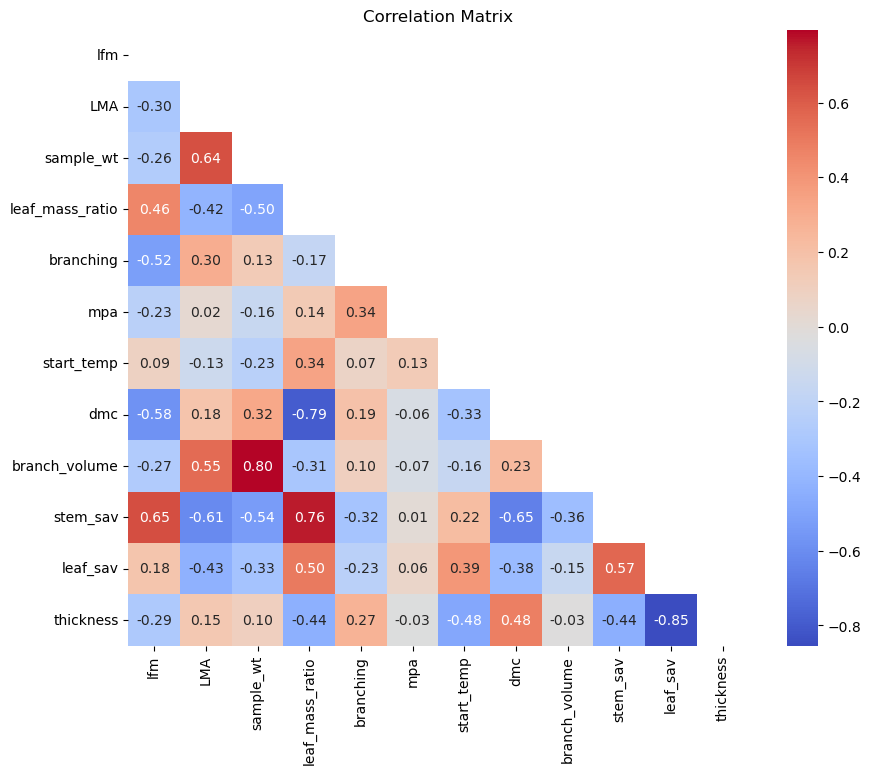

In [4]:
cols_num_use = ['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']

corrplot(flamog, cols_num_use)

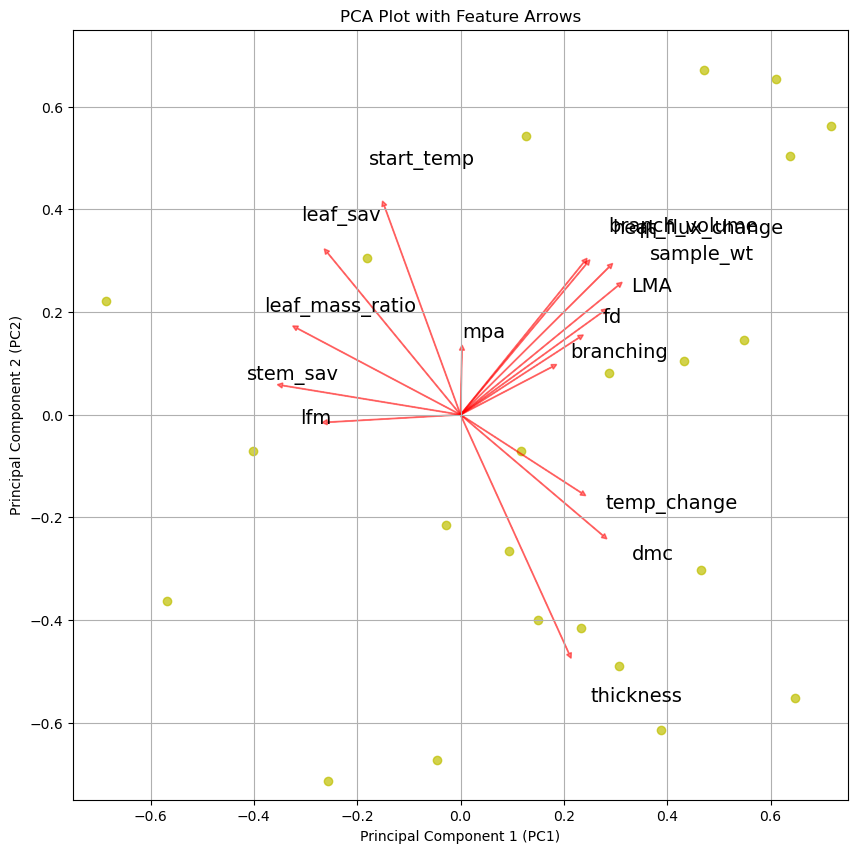

In [5]:
PCAplot(flamog, cols_num_use+['fh','fd','temp_change','heat_flux_change'])

# Modeling Preprocessing

In [6]:
# scale and center
cols_all = ['fh', 'fd', 'temp_change', 'heat_flux_change'] + cols_num_use
flam = scale_and_center(flamog, cols_all, cols_no_change=['plant_id', 'species', 'ignition'])

# declare as factors
flam['species'] = pd.Categorical(flam['species'])
flam['plant_id'] = pd.Categorical(flam['plant_id'])
flam['ignition'] = pd.Categorical(flam['ignition'])

# drop na's
print(len(flam))
cols_all_dpna = cols_all + ['plant_id', 'species', 'ignition']
flam.dropna(subset=cols_all_dpna, inplace=True)
print(len(flam))

# declare all possible IV cols to model
cols_use = cols_num_use #+ ['species']
print(cols_use)

165
158
['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']


<Axes: >

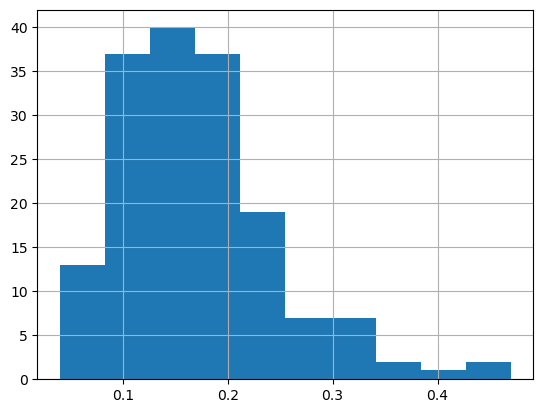

In [7]:
flamog.mpa.hist()

# Run Model Selector

### NOTE: Random effect is simply `plant_id`
- NO nested effects
- NO `species'

#### It was not possible to test all combinations. Therefore, only combinations of significnt interaction terms and all singletons will be tested.

In [8]:
mxs = len(cols_use)
mns = 0
mxi = 0
mni = 0

# Flame Height

In [9]:
yvar='fh'
cols=cols_use
df=flam

compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0         thickness  364.006952 -0.035795  7.120582e-01     True
1          leaf_sav  363.918737 -0.052448  6.383973e-01     True
2               mpa  363.735106  0.050483  5.231286e-01     True
3        start_temp  362.308272  0.107725  1.736033e-01     True
4               dmc  362.239188  0.139224  1.646000e-01     True
5   leaf_mass_ratio  361.985783 -0.176500  1.380189e-01    False
6               lfm  359.193313 -0.347787  2.636709e-02    False
7          stem_sav  357.100275 -0.591178  2.478364e-07    False
8               LMA  351.291339  0.516249  1.118780e-04    False
9         branching  347.983813  0.273746  2.927882e-05    False
10    branch_volume  346.249230  0.329668  1.482620e-05    False
11        sample_wt  310.075185  0.563605  1.117563e-15    False


ERROR: Formula model error: fh ~ leaf_sav*thickness

Columns present in sig. interaction terms: {'branching', 'lfm', 'sample_wt', 'mpa'}

Total Num. Cols : Num. Sig. Int. Cols;  12 : 4

Significant Interactions:
('lfm', 'sample_wt')
('sample_wt', 'mpa')
('sample_wt', 'branching')

Number of formulas: 4096
ERROR: Formula model error: fh ~ 


fh ~ sample_wt + branching + mpa + start_temp + stem_sav
fh ~ sample_wt + branching + mpa + start_temp + stem_sav + thickness
fh ~ LMA + sample_wt + branching + mpa + start_temp + stem_sav
fh ~ sample_wt + branching + mpa + start_temp + branch_volume + stem_sav
fh ~ sample_wt + branching + mpa + start_temp + stem_sav + leaf_sav


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fh       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.2476   
Min. group size:        8           Log-Likelihood:         -

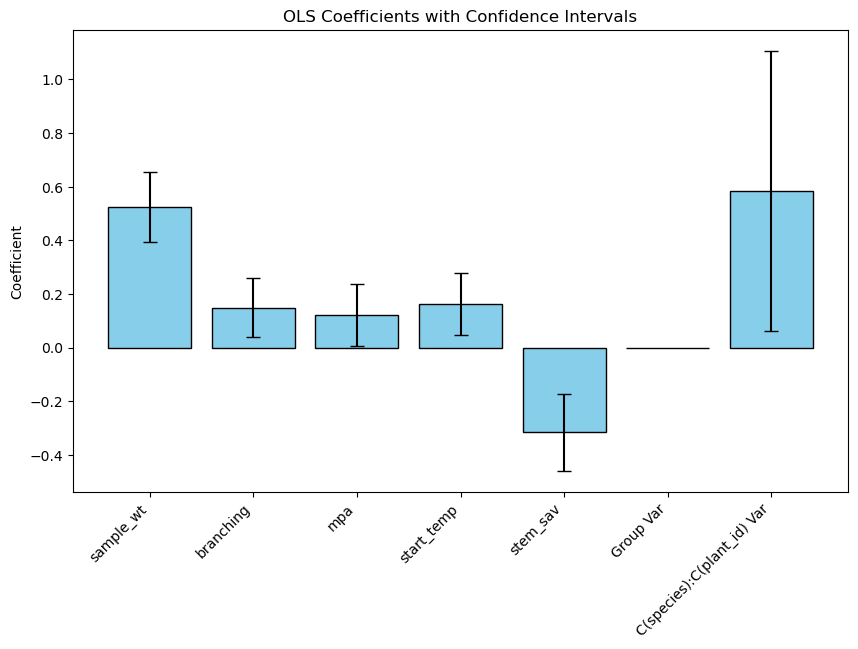

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fh       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.2509   
Min. group size:        8           Log-Likelihood:         -138.0382
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.055    0.069  0.793 0.428 -0.081  0.191
sample_wt                   0.522    0.066  7.910 0.000  0.393  0.651
branching                   0.160    0.056  2.825 0.005  0.049  0.270
mpa                         0.119    0.059  2.029 0.042  0.004  0.235
start_temp                  0.140   

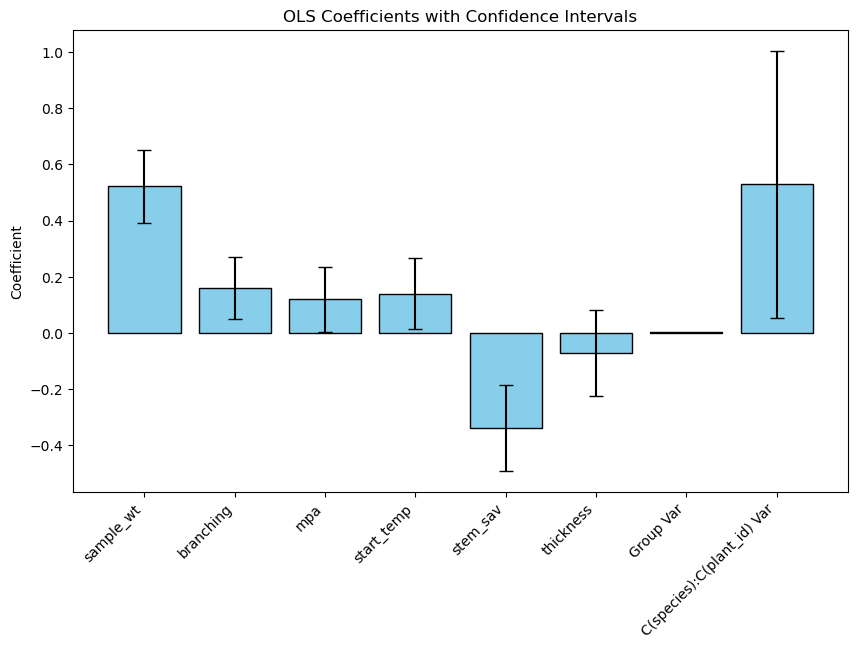

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fh       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.2438   
Min. group size:        8           Log-Likelihood:         -138.1197
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.060    0.071  0.848 0.396 -0.078  0.198
LMA                         0.064    0.093  0.684 0.494 -0.119  0.246
sample_wt                   0.507    0.071  7.184 0.000  0.369  0.646
branching                   0.147    0.055  2.652 0.008  0.038  0.256
mpa                         0.117   

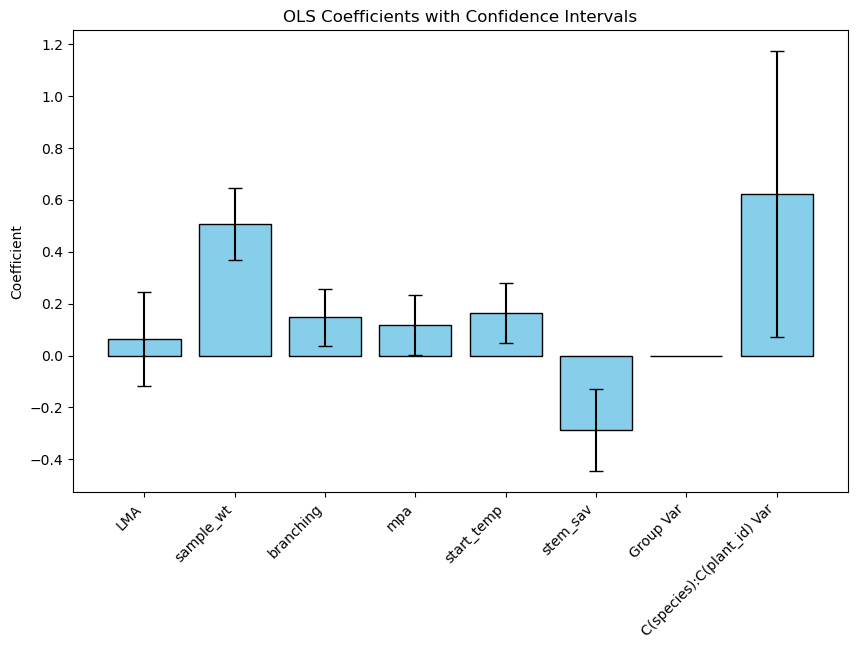

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fh       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.2478   
Min. group size:        8           Log-Likelihood:         -138.1348
Max. group size:        37          Converged:              No       
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.056    0.070  0.807 0.419 -0.081  0.193
sample_wt                   0.569    0.091  6.287 0.000  0.392  0.747
branching                   0.151    0.055  2.731 0.006  0.043  0.259
mpa                         0.123    0.059  2.089 0.037  0.008  0.239
start_temp                  0.165   

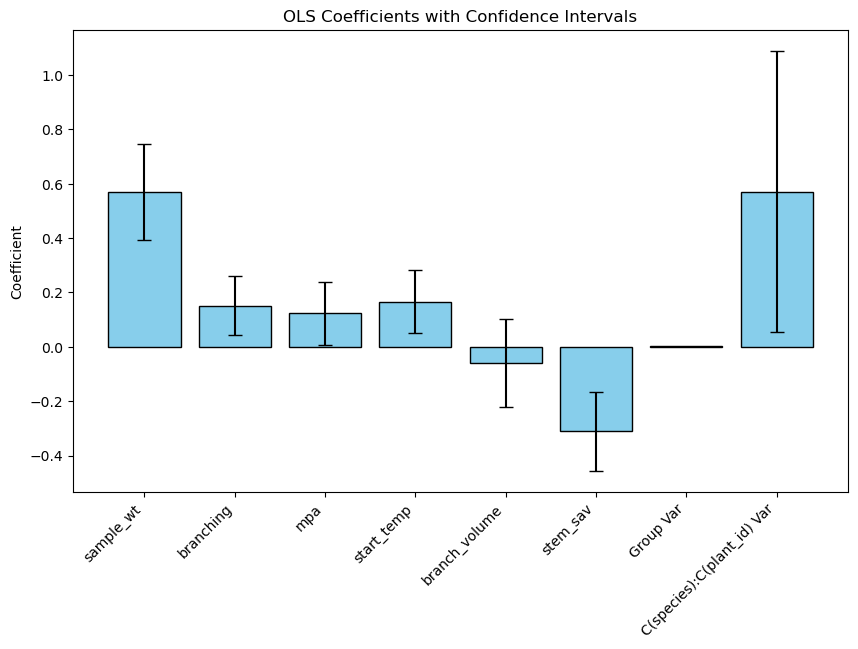

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     fh       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.2480   
Min. group size:        8           Log-Likelihood:         -138.2001
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.057    0.070  0.824 0.410 -0.079  0.194
sample_wt                   0.528    0.066  7.987 0.000  0.398  0.657
branching                   0.152    0.055  2.742 0.006  0.043  0.261
mpa                         0.121    0.059  2.047 0.041  0.005  0.236
start_temp                  0.153   

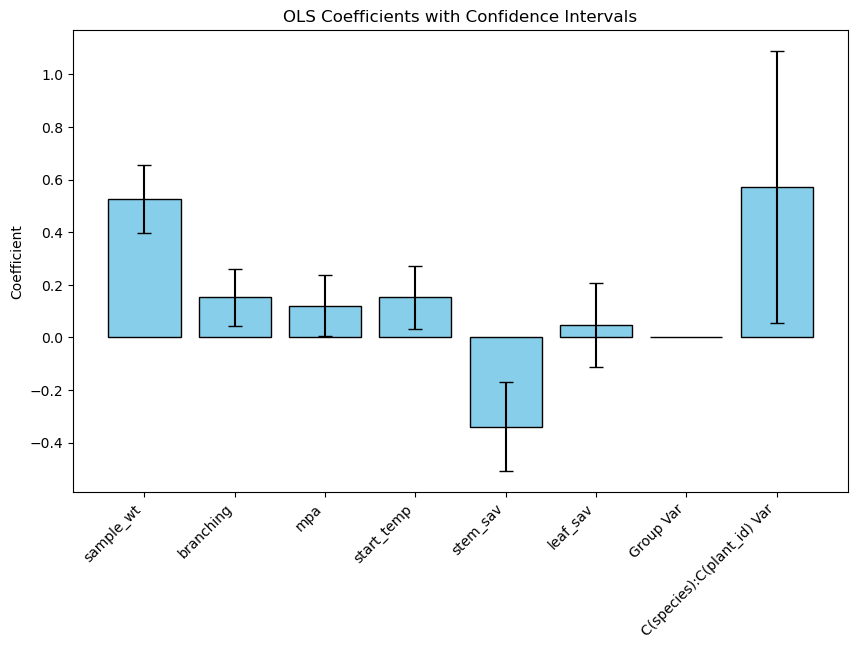

In [10]:
AIC_iterator(flam, cols_use, Y_VAR='fh',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Flame Duration

In [11]:
yvar='fd'
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0               mpa  436.873240 -0.030688  7.437746e-01     True
1        start_temp  436.079075 -0.065230  5.218623e-01     True
2         thickness  435.387128  0.080096  5.179140e-01     True
3          leaf_sav  435.007152 -0.100602  3.998897e-01     True
4               LMA  434.967441  0.233946  9.034159e-02     True
5   leaf_mass_ratio  434.235530 -0.190051  5.249440e-01    False
6               lfm  433.629983 -0.229844  1.616765e-01    False
7          stem_sav  433.615000 -0.317586  6.588064e-02    False
8         branching  433.207184  0.180716  5.759355e-02    False
9     branch_volume  425.968222  0.336634  8.489578e-04    False
10              dmc  424.962442  0.402439  3.168880e-04    False
11        sample_wt  412.060412  0.487190  4.197782e-09    False


In [12]:
AIC_iterator(flam, cols_use, Y_VAR='fd',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

ERROR: Formula model error: fd ~ leaf_sav*thickness

Columns present in sig. interaction terms: {'lfm', 'sample_wt', 'dmc'}

Total Num. Cols : Num. Sig. Int. Cols;  12 : 3

Significant Interactions:
('sample_wt', 'dmc')
('lfm', 'sample_wt')

Number of formulas: 4096
ERROR: Formula model error: fd ~ 


KeyboardInterrupt: 

# Temp Change

In [ ]:
yvar='temp_change'
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

In [ ]:
AIC_iterator(flam, cols_use, Y_VAR='temp_change',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Heat Flux Change

In [ ]:
yvar='heat_flux_change'
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

In [ ]:
AIC_iterator(flam, cols_use, Y_VAR='heat_flux_change',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)